In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [17]:
# Data Preparation

# Parameters
tickers = ['AAPL', 'COKE', 'VZ', 'F']
tickers.sort()

start = '2016-01-01'

# YF download
df = yf.download(tickers, start=start)

# Reformat Dataframe
df = df.stack().reset_index()

# Add daily return column
df['Return'] = df.groupby("Ticker")['Adj Close'].pct_change()

df = df.dropna()

df

[*********************100%%**********************]  4 of 4 completed
C:\Users\andre\AppData\Local\Temp\ipykernel_14448\1719358244.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack().reset_index()


Price,Date,Ticker,Adj Close,Close,High,Low,Open,Volume,Return
4,2016-01-05,AAPL,23.288246,25.677500,26.462500,25.602501,26.437500,223164000.0,-0.025059
5,2016-01-05,COKE,166.498108,176.740005,179.410004,174.300003,177.020004,32600.0,0.009654
6,2016-01-05,F,8.630338,13.720000,14.000000,13.510000,13.970000,50267500.0,-0.017895
7,2016-01-05,VZ,29.956106,46.500000,46.549999,45.630001,46.200001,15632800.0,0.013734
8,2016-01-06,AAPL,22.832504,25.174999,25.592501,24.967501,25.139999,273829600.0,-0.019570
...,...,...,...,...,...,...,...,...,...
8670,2024-08-14,F,10.180000,10.180000,10.240000,10.050000,10.160000,36977100.0,0.003945
8671,2024-08-14,VZ,40.900002,40.900002,41.099998,40.490002,40.599998,10930500.0,0.002943
8672,2024-08-15,AAPL,225.085007,225.085007,225.339996,222.759995,224.550003,27853794.0,0.015177
8673,2024-08-15,COKE,1280.959961,1280.959961,1280.959961,1253.406494,1267.930054,21533.0,0.018114


In [18]:
# Create assets dataframe

assets = df.groupby('Ticker')['Return'].mean().rename("Expected Return").to_frame().reset_index()

assets['Volatility'] = df.groupby('Ticker')['Return'].std().to_list()

assets['Sharpe Ratio'] = assets['Expected Return'] / assets['Volatility']

assets

,Ticker,Expected Return,Volatility,Sharpe Ratio
0,AAPL,0.001202,0.018282,0.065763
1,COKE,0.001234,0.023884,0.051654
2,F,0.000358,0.023564,0.015189
3,VZ,0.000227,0.012396,0.018290


In [19]:
# Returns dataframe
return_matrix = df[['Date','Ticker','Return']].pivot(index='Date', columns='Ticker', values='Return').dropna()

return_matrix

Ticker,AAPL,COKE,F,VZ
Date,,,,
2016-01-05,-0.025059,0.009654,-0.017895,0.013734
2016-01-06,-0.019570,0.018162,-0.044461,-0.009035
2016-01-07,-0.042205,-0.014004,-0.031274,-0.005492
2016-01-08,0.005287,0.002649,-0.012598,-0.009720
2016-01-11,0.016192,-0.029961,0.018341,0.005800
...,...,...,...,...
2024-08-08,0.016633,0.005090,0.036847,0.005958
2024-08-09,0.013736,-0.000333,-0.002961,0.005676
2024-08-12,0.007130,-0.004208,-0.023762,-0.005399


In [20]:
# Covariance Matrix
cov_matrix = return_matrix.cov().values

cov_matrix

array([[3.34290862e-04, 1.08434514e-04, 1.47068240e-04, 5.05549157e-05],
       [1.08434514e-04, 5.70596774e-04, 1.38300374e-04, 6.38493515e-05],
       [1.47068240e-04, 1.38300374e-04, 5.55187738e-04, 6.82637027e-05],
       [5.05549157e-05, 6.38493515e-05, 6.82637027e-05, 1.53658945e-04]])

In [21]:
# Expected Returns Vector
expected_returns = assets['Expected Return'].values

expected_returns

array([0.00120227, 0.00123372, 0.00035792, 0.00022673])

In [22]:
# Portfolio metric functions
def portfolio_return(weights, expected_returns):
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(np.matmul(weights,cov_matrix),weights.T))

def negative_sharpe_ratio(weights, expected_returns, cov_matrix):
    port_er = portfolio_return(weights, expected_returns)
    port_std = portfolio_volatility(weights, cov_matrix)
    return -port_er / port_std

In [23]:
# Display Weights Function
def display_weights(tickers, weights):
    df = pd.DataFrame()
    df['Ticker'] = tickers
    df['Weight'] = [round(weight, 2) for weight in weights]

    display(df)

In [24]:
# Baseline results

# Initial Weights
size = len(tickers)
initial_weights = np.array([1/size] * size)

# Baseline Results
port_return = portfolio_return(initial_weights, expected_returns)
port_volatiliy = portfolio_volatility(initial_weights,cov_matrix)
port_sharpe = port_return / port_volatiliy

#Display
display_weights(tickers, initial_weights)
print(f"Portfolio Return: {round(port_return,2)} %")
print(f"Portfolio Volatility: {round(port_volatiliy,2)} %")
print(f"Portfolio Sharpe Ratio: {round(port_sharpe,2)}")

,Ticker,Weight
0,AAPL,0.25
1,COKE,0.25
2,F,0.25
3,VZ,0.25


Portfolio Return: 0.0 %
Portfolio Volatility: 0.01 %
Portfolio Sharpe Ratio: 0.06


In [25]:
# Optimization

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((-1, 1) for _ in range(len(tickers)))  # each weight between -1 and 1

# Result
result = minimize(negative_sharpe_ratio, initial_weights, 
                  args=(expected_returns, cov_matrix),
                  method='SLSQP', constraints=constraints)

optimal_weights = result.x

optimal_weights

array([ 0.76588707,  0.3899769 , -0.1498201 , -0.00604387])

In [26]:
# Optimal Results
opt_port_return = portfolio_return(optimal_weights, expected_returns)
opt_port_volatility = portfolio_volatility(optimal_weights,cov_matrix)
opt_port_sharpe_ratio = opt_port_return / opt_port_volatility

# Display
display_weights(tickers,optimal_weights)
print(f"Optimized Portfolio Return: {round(opt_port_return,2)} %")
print(f"Optimized Portfolio Volatility: {round(opt_port_volatility,2)} %")
print(f"Optimized Portfolio Sharpe Ratio: {round(opt_port_sharpe_ratio,2)}")

,Ticker,Weight
0,AAPL,0.77
1,COKE,0.39
2,F,-0.15
3,VZ,-0.01


Optimized Portfolio Return: 0.0 %
Optimized Portfolio Volatility: 0.02 %
Optimized Portfolio Sharpe Ratio: 0.08


In [27]:
# Efficient Frontier Chart

# Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((-1, 1) for _ in range(len(tickers)))

# Mean Variance Efficient function
def mve_portfolio(target_return, expected_returns, cov_matrix):
    n = len(tickers)
    args = (expected_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(portfolio_volatility, n*[1./n,], args=args[1],
                      method='SLSQP', constraints=constraints)
    return result.x

In [28]:
# Pro
n_points = 100
target_returns = np.linspace(0,2*opt_port_return, n_points)
mve_portfolios = [mve_portfolio(target, expected_returns, cov_matrix) for target in target_returns]

returns = [portfolio_return(w, expected_returns) for w in mve_portfolios]
volatilities = [portfolio_volatility(w, cov_matrix) for w in mve_portfolios]

portfolios = pd.DataFrame()
portfolios['Name'] = [f"Portfolio {x+1}" for x in range(len(mve_portfolios))]

for index in range(len(tickers)):
    portfolios[tickers[index]] = np.array([row[index] for row in mve_portfolios])
    portfolios[tickers[index]] = round(portfolios[tickers[index]],2)
    
portfolios['Expected Return'] = returns
portfolios['Volatility'] = volatilities
portfolios['Sharpe Ratio'] = portfolios['Expected Return'] / portfolios['Volatility']

portfolios

,Name,AAPL,COKE,F,VZ,Expected Return,Volatility,Sharpe Ratio
0,Portfolio 1,-0.17,-0.09,0.20,1.06,-1.127961e-14,0.013967,-8.076105e-13
1,Portfolio 2,-0.15,-0.08,0.19,1.04,2.721066e-05,0.013689,1.987705e-03
2,Portfolio 3,-0.13,-0.07,0.19,1.01,5.442131e-05,0.013422,4.054655e-03
3,Portfolio 4,-0.11,-0.06,0.18,0.99,8.163197e-05,0.013165,6.200883e-03
4,Portfolio 5,-0.09,-0.05,0.17,0.97,1.088426e-04,0.012918,8.425653e-03
...,...,...,...,...,...,...,...,...
95,Portfolio 96,1.61,0.85,-0.46,-0.99,2.585012e-03,0.036098,7.161147e-02
96,Portfolio 97,1.62,0.86,-0.47,-1.01,2.612223e-03,0.036530,7.150923e-02
97,Portfolio 98,1.64,0.87,-0.48,-1.03,2.639434e-03,0.036963,7.140840e-02
98,Portfolio 99,1.66,0.88,-0.48,-1.05,2.666644e-03,0.037396,7.130896e-02


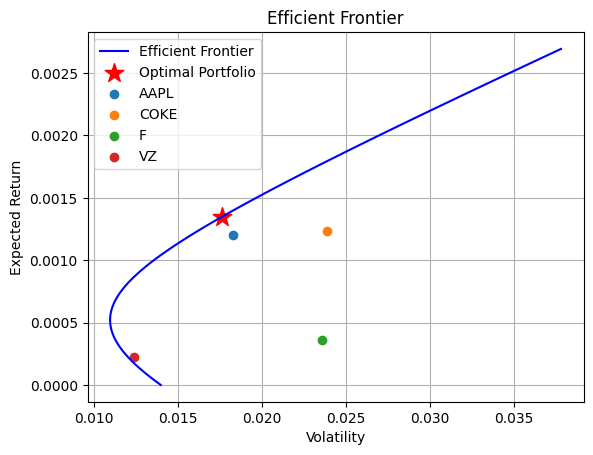

In [29]:
plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
plt.scatter(opt_port_volatility, opt_port_return, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Expected Return'].iloc[i], label=ticker)

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)
plt.show()

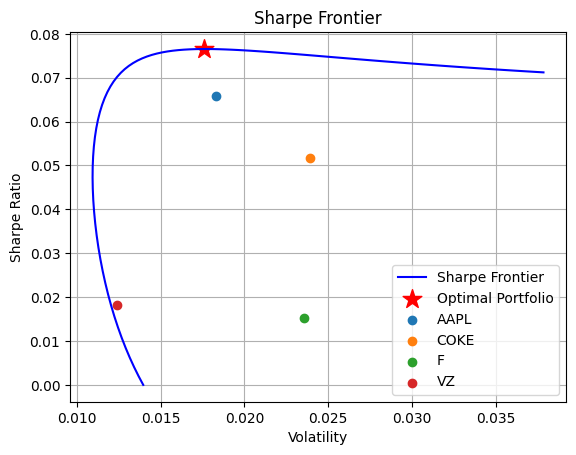

In [30]:
# Sharpe Graph
plt.plot(portfolios['Volatility'], portfolios['Sharpe Ratio'], 'b-', label='Sharpe Frontier')
plt.scatter(opt_port_volatility, opt_port_sharpe_ratio, color='r', marker='*', s=200, label='Optimal Portfolio')

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(assets['Volatility'].iloc[i], assets['Sharpe Ratio'].iloc[i], label=ticker)

    
plt.xlabel('Volatility')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Frontier')
plt.legend()
plt.grid(True)
plt.show()